This notebook is meant to be a proof of concept for ideas discussed in [__this thread__](https://www.kaggle.com/c/mercari-price-suggestion-challenge/discussion/45291). Hopefully it shows that cross-validation can be done even within existing time limits, and that it can be done even better than here with multi-processing and other tricks. In my hands cross-validation has produced scores that agree very well with LB scores - the difference is usually on the order of 0.001. That should give us comfort compared to single runs of individual methods on fold splits and random seeds that are crafted to give the best LB score.

Further down the line there is a brief example of how to use out-of-fold predictions to calculate linear blending weights by minimization. Several plots closer to the end will show how individual methods differ in types of prediction errors. Lastly, all out-of-fold files and submission files will be saved if you wish to play with them locally.

Fairness warning: This script will not give you a 0.43xx score at the push of a button. You will have to work on your own and modify concepts presented here in order to get that kind of score.

A __big thank you__ to [__@apapiu__](https://www.kaggle.com/apapiu) for his original [__Ridge script__](https://www.kaggle.com/apapiu/ridge-script), as the initial data processing here is based on his work. It is a shame that his script has less than 40 votes, while other scripts using his strategy have more votes just because they advertise better LB scores. You know what to do if you agree with me.

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import scipy

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm as lgb
from scipy.optimize import minimize
%matplotlib inline

import gc


def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' %
              (thour, tmin, round(tsec, 2)))


def rmse_min_func(weights):
    final_prediction = 0
    for weight, prediction in zip(weights, blend_train):
        final_prediction += weight * prediction
    return np.sqrt(mean_squared_error(y_train, final_prediction))


#starttime = timer(None)

start_time = timer(None)
NUM_BRANDS = 2500
NAME_MIN_DF = 10
MAX_FEAT_DESCP = 50000
print('Reading in Data')

df_train = pd.read_csv('../input/train.tsv', sep='\t')
df_test = pd.read_csv('../input/test.tsv', sep='\t')
y_train = np.log1p(df_train['price'])
tr_ids = df_train['train_id'].values.astype(np.int32)
df_train.drop(['price', 'train_id'], axis=1, inplace=True)
te_ids = df_test['test_id'].values.astype(np.int32)
df_test.drop(['test_id'], axis=1, inplace=True)
df = pd.concat([df_train, df_test])
nrow_train = df_train.shape[0]

del df_train, df_test
gc.collect()

df['category_name'] = df['category_name'].fillna('Other').astype('category')
df['brand_name'] = df['brand_name'].fillna('unknown')

pop_brands = df['brand_name'].value_counts().index[:NUM_BRANDS]
df.loc[~df['brand_name'].isin(pop_brands), 'brand_name'] = 'Other'

df['item_description'] = df['item_description'].fillna('None')
df['item_condition_id'] = df['item_condition_id'].astype('category')
df['brand_name'] = df['brand_name'].astype('category')

print('Encodings')
count = CountVectorizer(min_df=NAME_MIN_DF)
X_name = count.fit_transform(df['name'])

print('Category Encoders')
unique_categories = pd.Series('/'.join(df['category_name'].unique().astype(
    'str')).split('/')).unique()
count_category = CountVectorizer()
X_category = count_category.fit_transform(df['category_name'])

print('Descp encoders')
count_descp = TfidfVectorizer(max_features=MAX_FEAT_DESCP,
                              ngram_range=(1, 3),
                              stop_words='english')
X_descp = count_descp.fit_transform(df['item_description'])

print('Brand encoders')
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(df['brand_name'])

print('Dummy Encoders')
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(df[[
    'item_condition_id', 'shipping'
]], sparse=True).values)

X = scipy.sparse.hstack((X_dummies, X_descp, X_brand, X_category,
                         X_name)).tocsr()

print([X_dummies.shape, X_category.shape, X_name.shape, X_descp.shape,
       X_brand.shape])

X_train = X[:nrow_train]
X_test = X[nrow_train:]
timer(start_time)

Reading in Data
Encodings
Category Encoders
Descp encoders
Brand encoders
Dummy Encoders
[(2175894, 6), (2175894, 1021), (2175894, 21257), (2175894, 50000), (2175894, 2501)]

 Time taken: 0 hours 6 minutes and 16.32 seconds.


Doing cross-validation in this block. Time-permitting, we'd be doing 5- or 10-fold CV and few parameters would have been different in individual models. It should not be a problem at all to include 2-3 additional models that have training times similar to Ridge or SGDRegressor.

In [2]:
# This number of folds is forced by time limit
folds = 3

sgd_cv_sum = 0
ridge_cv_sum = 0
lgb_cv_sum = 0
lgb_pred = []
sgd_pred = []
ridge_pred = []
lgb_fpred = []
sgd_fpred = []
ridge_fpred = []

avreal = y_train
lgb_avpred = np.zeros(X_train.shape[0])
sgd_avpred = np.zeros(X_train.shape[0])
ridge_avpred = np.zeros(X_train.shape[0])
idpred = tr_ids

blend_train = []
blend_test = []

train_time = timer(None)
kf = KFold(n_splits=folds, random_state=1001)
for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    start_time = timer(None)
    Xtrain, Xval = X_train[train_index], X_train[val_index]
    ytrain, yval = y_train[train_index], y_train[val_index]

    model = SGDRegressor(penalty='l2',
                         loss='squared_epsilon_insensitive',
                         max_iter=200,
                         tol=0.00001,
                         epsilon=0.0001,
                         learning_rate='invscaling',
                         fit_intercept=False,
                         alpha=1e-10,
                         l1_ratio=0.09,
                         shuffle=True,
                         verbose=0,
                         random_state=1001)
    model.fit(Xtrain, ytrain)
    sgd_scores_val = model.predict(Xval)
    sgd_RMSLE = np.sqrt(mean_squared_error(yval, sgd_scores_val))
    print('\n Fold %02d SGD RMSLE: %.6f' % ((i + 1), sgd_RMSLE))
    sgd_y_pred = model.predict(X_test)

    model = Ridge(alpha=4.75,
                  solver='sag',
                  fit_intercept=False,
                  random_state=1001,
                  max_iter=1000)
    model.fit(Xtrain, ytrain)
    ridge_scores_val = model.predict(Xval)
    ridge_RMSLE = np.sqrt(mean_squared_error(yval, ridge_scores_val))
    print(' Fold %02d Ridge RMSLE: %.6f' % ((i + 1), ridge_RMSLE))
    ridge_y_pred = model.predict(X_test)

    params = {
        'boosting': 'gbdt',
#        'max_bin'          : 511,
        'max_depth': 7,
        'min_data_in_leaf': 80,
        'num_leaves': 40,
        'learning_rate': 0.75,
        'objective': 'regression',
        'metric': 'rmse',
        'nthread': 4,
        'bagging_freq': 1,
        'subsample': 0.94,
        'colsample_bytree': 0.7,
        'min_child_weight': 17,
        'is_unbalance': False,
        'verbose': -1,
        'seed': 1001
    }

    dtrain = lgb.Dataset(Xtrain, label=ytrain, max_bin=4095)
    dval = lgb.Dataset(Xval, label=yval, max_bin=4095)
    watchlist = [dtrain, dval]
    watchlist_names = ['train', 'val']

    model = lgb.train(params,
                      train_set=dtrain,
                      num_boost_round=1800,
                      valid_sets=watchlist,
                      valid_names=watchlist_names,
                      early_stopping_rounds=100,
                      verbose_eval=50)
    lgb_scores_val = model.predict(Xval)
    lgb_RMSLE = np.sqrt(mean_squared_error(yval, lgb_scores_val))
    print(' Fold %02d LightGBM RMSLE: %.6f' % ((i + 1), lgb_RMSLE))
    lgb_y_pred = model.predict(X_test)

    del Xtrain, Xval
    gc.collect()

    timer(start_time)

    sgd_avpred[val_index] = sgd_scores_val
    ridge_avpred[val_index] = ridge_scores_val
    lgb_avpred[val_index] = lgb_scores_val

    if i > 0:
        sgd_fpred = sgd_pred + sgd_y_pred
        ridge_fpred = ridge_pred + ridge_y_pred
        lgb_fpred = lgb_pred + lgb_y_pred
    else:
        sgd_fpred = sgd_y_pred
        ridge_fpred = ridge_y_pred
        lgb_fpred = lgb_y_pred
    sgd_pred = sgd_fpred
    ridge_pred = ridge_fpred
    lgb_pred = lgb_fpred
    sgd_cv_sum = sgd_cv_sum + sgd_RMSLE
    ridge_cv_sum = ridge_cv_sum + ridge_RMSLE
    lgb_cv_sum = lgb_cv_sum + lgb_RMSLE

timer(train_time)

sgd_cv_score = (sgd_cv_sum / folds)
ridge_cv_score = (ridge_cv_sum / folds)
lgb_cv_score = (lgb_cv_sum / folds)
sgd_oof_RMSLE = np.sqrt(mean_squared_error(avreal, sgd_avpred))
ridge_oof_RMSLE = np.sqrt(mean_squared_error(avreal, ridge_avpred))
lgb_oof_RMSLE = np.sqrt(mean_squared_error(avreal, lgb_avpred))

print('\n Average SGD RMSLE:\t%.6f' % sgd_cv_score)
print(' Out-of-fold SGD RMSLE:\t%.6f' % sgd_oof_RMSLE)
print('\n Average Ridge RMSLE:\t%.6f' % ridge_cv_score)
print(' Out-of-fold Ridge RMSLE:\t%.6f' % ridge_oof_RMSLE)
print('\n Average LightGBM RMSLE:\t%.6f' % lgb_cv_score)
print(' Out-of-fold LightGBM RMSLE:\t%.6f' % lgb_oof_RMSLE)
sgd_score = round(sgd_oof_RMSLE, 6)
ridge_score = round(ridge_oof_RMSLE, 6)
lgb_score = round(lgb_oof_RMSLE, 6)

sgd_mpred = sgd_pred / folds
ridge_mpred = ridge_pred / folds
lgb_mpred = lgb_pred / folds

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



 Fold 01 SGD RMSLE: 0.469950
 Fold 01 Ridge RMSLE: 0.467068


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 0.529916	val's rmse: 0.532378
[100]	train's rmse: 0.50729	val's rmse: 0.512744
[150]	train's rmse: 0.493766	val's rmse: 0.501305
[200]	train's rmse: 0.48512	val's rmse: 0.494907
[250]	train's rmse: 0.479216	val's rmse: 0.490449
[300]	train's rmse: 0.474177	val's rmse: 0.487064
[350]	train's rmse: 0.46931	val's rmse: 0.483732
[400]	train's rmse: 0.465016	val's rmse: 0.481211
[450]	train's rmse: 0.462274	val's rmse: 0.479987
[500]	train's rmse: 0.459988	val's rmse: 0.478926
[550]	train's rmse: 0.457505	val's rmse: 0.477847
[600]	train's rmse: 0.455286	val's rmse: 0.476864
[650]	train's rmse: 0.453626	val's rmse: 0.47637
[700]	train's rmse: 0.451964	val's rmse: 0.475894
[750]	train's rmse: 0.450386	val's rmse: 0.475397
[800]	train's rmse: 0.449045	val's rmse: 0.475054
[850]	train's rmse: 0.447638	val's rmse: 0.474509
[900]	train's rmse: 0.446032	val's rmse: 0.474078
[950]	train's rmse: 0.444584	val's rmse: 0

This procedure finds linear blending weights from out-of-fold predictions by simple minimization. It doesn't take very long to complete, and I would normally use N-fold validation with the same folds as above. However, for the purpose of this competition the gain from doing so is negligible compared to extra time it takes.

It may be worth your while to read the inline comments below about negative weights, and to try this notebook with and without them.

In [3]:
blend_time = timer(None)

blend_train.append(sgd_avpred)
blend_train.append(ridge_avpred)
blend_train.append(lgb_avpred)
blend_train = np.array(blend_train)

blend_test.append(sgd_mpred)
blend_test.append(ridge_mpred)
blend_test.append(lgb_mpred)
blend_test = np.array(blend_test)

print('\n Finding Blending Weights ...')
res_list = []
weights_list = []
#for k in range(1000):
for k in range(20):
    starting_values = np.random.uniform(size=len(blend_train))

    #######
    # I used to think that weights should not be negative - many agree with that.
    # I've come around on that issues as negative weights sometimes do help.
    # If you don't think so, just swap the two lines below.
    #######

#    bounds = [(0, 1)]*len(blend_train)
    bounds = [(-1, 1)] * len(blend_train)

    res = minimize(rmse_min_func,
                   starting_values,
                   method='L-BFGS-B',
                   bounds=bounds,
                   options={'disp': False,
                            'maxiter': 100000})
    res_list.append(res['fun'])
    weights_list.append(res['x'])
    print('{iter}\tScore: {score}\tWeights: {weights}'.format(
        iter=(k + 1),
        score=res['fun'],
        weights='\t'.join([str(item) for item in res['x']])))

bestSC = np.min(res_list)
bestWght = weights_list[np.argmin(res_list)]
weights = bestWght
blend_score = round(bestSC, 6)

print('\n Ensemble Score: {best_score}'.format(best_score=bestSC))
print('\n Best Weights: {weights}'.format(weights=bestWght))

train_prices = np.zeros(len(blend_train[0]))
test_prices = np.zeros(len(blend_test[0]))

print('\n Your final model:')
for k in range(len(blend_test)):
    print(' %.6f * model-%d' % (weights[k], (k + 1)))
    test_prices += blend_test[k] * weights[k]

for k in range(len(blend_train)):
    train_prices += blend_train[k] * weights[k]

timer(blend_time)


 Finding Blending Weights ...
1	Score: 0.45279672794059844	Weights: -0.4305837983	0.952080897456	0.478912230554
2	Score: 0.4527967279447509	Weights: -0.430548616663	0.95205000764	0.478907848935
3	Score: 0.4527967280315461	Weights: -0.430500358213	0.951969056585	0.478939817894
4	Score: 0.45279672794818127	Weights: -0.430577425903	0.952083618851	0.4789027443
5	Score: 0.4527967303946787	Weights: -0.430670950762	0.952327054782	0.478761998953
6	Score: 0.45279672794062353	Weights: -0.430584311267	0.952081962492	0.478911677415
7	Score: 0.45279672796604153	Weights: -0.430635680136	0.952115180561	0.478930092851
8	Score: 0.452796727946529	Weights: -0.430596271391	0.95209877508	0.478906307044
9	Score: 0.4527967279406076	Weights: -0.430583345712	0.952080575476	0.478912079177
10	Score: 0.45279672796494863	Weights: -0.430670566002	0.952172075825	0.478907818915
11	Score: 0.4527967279452347	Weights: -0.430567303655	0.952057851182	0.478918550129
12	Score: 0.45279672794065245	Weights: -0.43058771054	0.

Hopefully the plots show that Ridge and SGDRegressor tend to under-predict prices as a general rule. That is especially severe for many items priced at \$1000+. LightGBM does better when it comes to under-predicting \$1000+ items, but over-predicts a good number of items that cost \$250-\$1000.


 Making scatter plots of actual vs. predicted prices ...


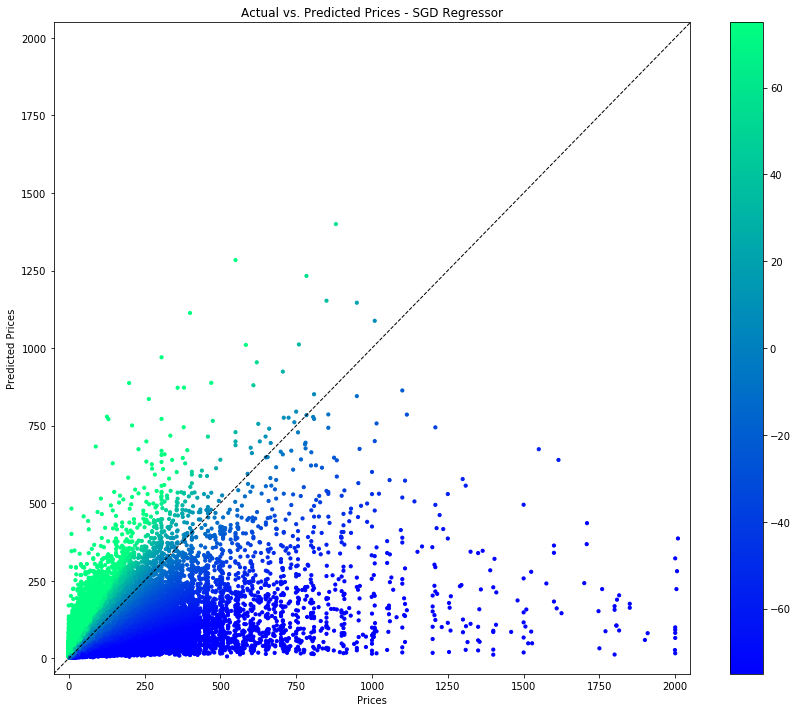

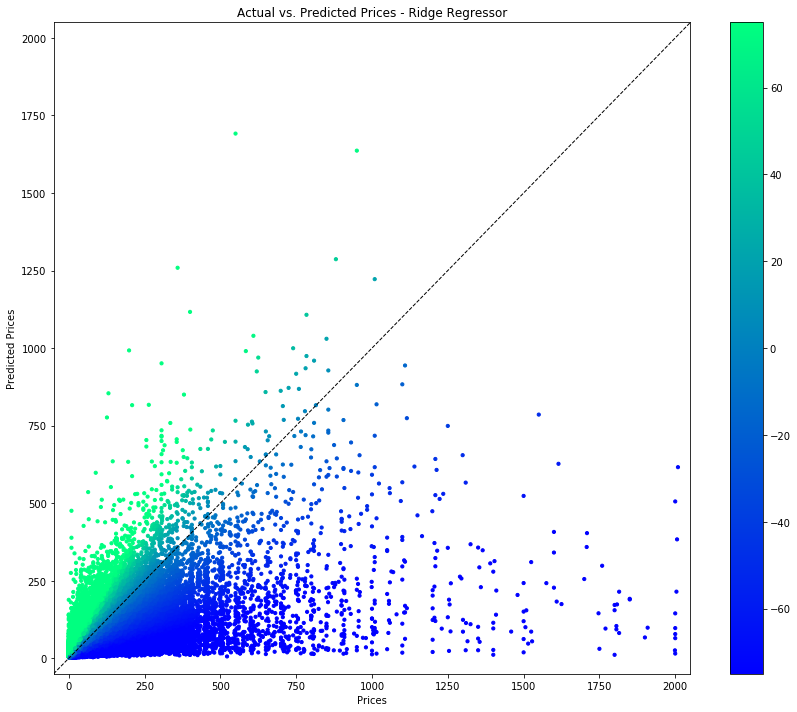

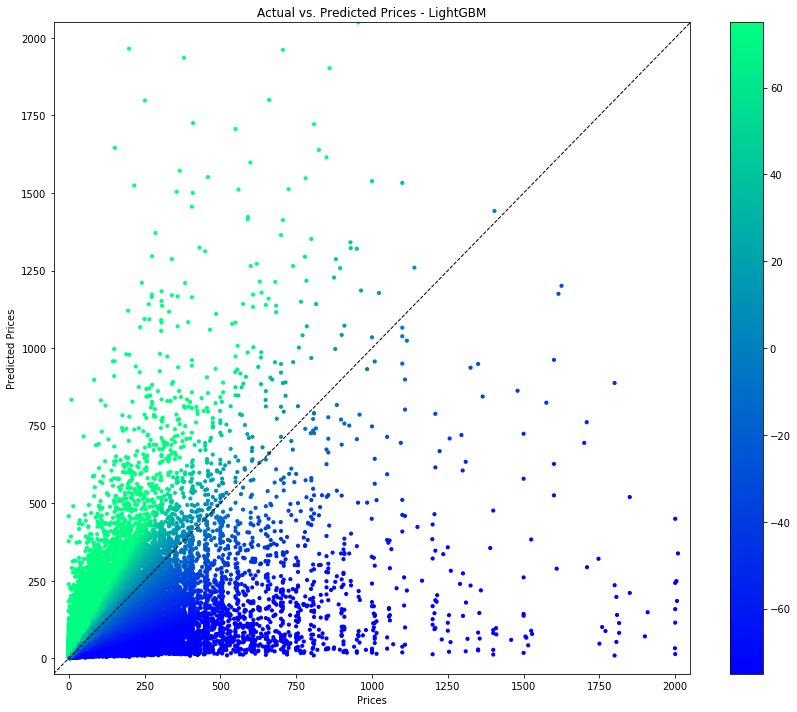

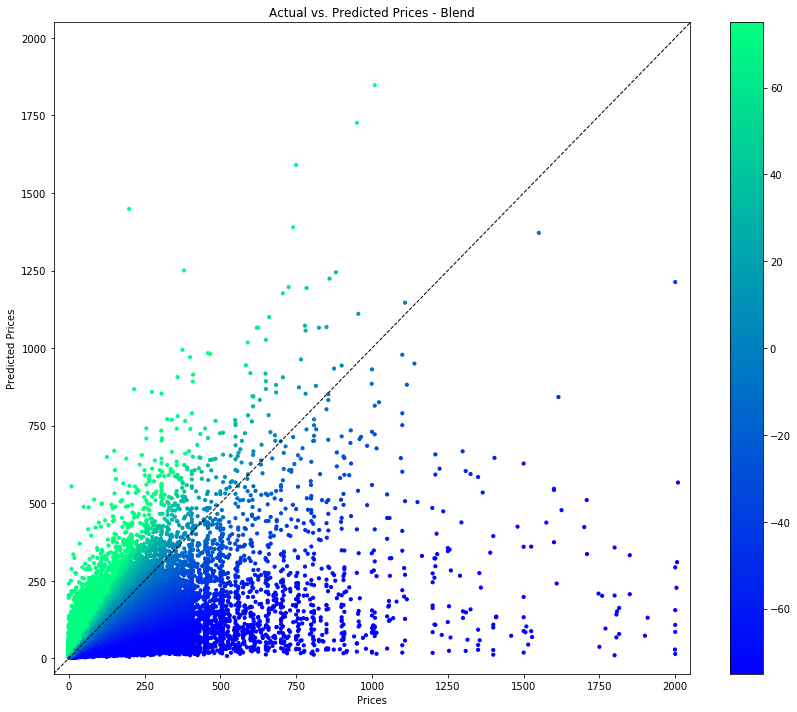

In [4]:
# Plotting
print('\n Making scatter plots of actual vs. predicted prices ...')
x_true = np.expm1(avreal)

x_pred = np.expm1(sgd_avpred)
#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('winter')
# Normalized prediction error clipped so the color-coding covers -75% to 75% range
x_diff = np.clip(100 * ((x_pred - x_true) / x_true), -75, 75)
plt.figure(1, figsize=(12, 10))
plt.title('Actual vs. Predicted Prices - SGD Regressor')
plt.scatter(x_true, x_pred, c=x_diff, s=10, cmap=cm)
plt.colorbar()
plt.plot([x_true.min() - 50, x_true.max() + 50],
         [x_true.min() - 50, x_true.max() + 50],
         'k--',
         lw=1)
plt.xlabel('Prices')
plt.ylabel('Predicted Prices')
plt.xlim(-50, 2050)
plt.ylim(-50, 2050)
plt.tight_layout()
plt.savefig('Mercari-SGDRegressor-3fold-train-predictions-00-v1.png')
plt.show()
#plt.close(1)

x_pred = np.expm1(ridge_avpred)
#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('winter')
# Normalized prediction error clipped so the color-coding covers -75% to 75% range
x_diff = np.clip(100 * ((x_pred - x_true) / x_true), -75, 75)
plt.figure(2, figsize=(12, 10))
plt.title('Actual vs. Predicted Prices - Ridge Regressor')
plt.scatter(x_true, x_pred, c=x_diff, s=10, cmap=cm)
plt.colorbar()
plt.plot([x_true.min() - 50, x_true.max() + 50],
         [x_true.min() - 50, x_true.max() + 50],
         'k--',
         lw=1)
plt.xlabel('Prices')
plt.ylabel('Predicted Prices')
plt.xlim(-50, 2050)
plt.ylim(-50, 2050)
plt.tight_layout()
plt.savefig('Mercari-Ridge-3fold-train-predictions-00-v1.png')
plt.show()
#plt.close(2)

x_pred = np.expm1(lgb_avpred)
#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('winter')
# Normalized prediction error clipped so the color-coding covers -75% to 75% range
x_diff = np.clip(100 * ((x_pred - x_true) / x_true), -75, 75)
plt.figure(3, figsize=(12, 10))
plt.title('Actual vs. Predicted Prices - LightGBM')
plt.scatter(x_true, x_pred, c=x_diff, s=10, cmap=cm)
plt.colorbar()
plt.plot([x_true.min() - 50, x_true.max() + 50],
         [x_true.min() - 50, x_true.max() + 50],
         'k--',
         lw=1)
plt.xlabel('Prices')
plt.ylabel('Predicted Prices')
plt.xlim(-50, 2050)
plt.ylim(-50, 2050)
plt.tight_layout()
plt.savefig('Mercari-LightGBM-3fold-train-predictions-00-v1.png')
plt.show()
#plt.close(3)

x_pred = np.expm1(train_prices)
#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('winter')
# Normalized prediction error clipped so the color-coding covers -75% to 75% range
x_diff = np.clip(100 * ((x_pred - x_true) / x_true), -75, 75)
plt.figure(4, figsize=(12, 10))
plt.title('Actual vs. Predicted Prices - Blend')
plt.scatter(x_true, x_pred, c=x_diff, s=10, cmap=cm)
plt.colorbar()
plt.plot([x_true.min() - 50, x_true.max() + 50],
         [x_true.min() - 50, x_true.max() + 50],
         'k--',
         lw=1)
plt.xlabel('Prices')
plt.ylabel('Predicted Prices')
plt.xlim(-50, 2050)
plt.ylim(-50, 2050)
plt.tight_layout()
plt.savefig('Mercari-blend-3fold-train-predictions-00-v1.png')
plt.show()
#plt.close(4)

Saving all the files in this block. Note that file names have corresponding out-of-fold scores in them, as well as unique time stamps. That's my usual practice, but it should be avoided for production scripts per Kaggle guidelines.

In [5]:
now = datetime.now()
oof_result = pd.DataFrame(np.expm1(avreal), columns=['price'])
oof_result['prediction'] = np.expm1(sgd_avpred)
oof_result['train_id'] = idpred
oof_result['train_id'] = oof_result['train_id'].astype(np.int32)
oof_result.sort_values('train_id', inplace=True)
oof_result = oof_result[['train_id', 'price', 'prediction']]
sub_file = 'train_SGDRegressor-3fold-00-v1-oof_' + str(sgd_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing out-of-fold train file::  %s' % sub_file)
oof_result.to_csv(sub_file, index=False, float_format='%.6f')

result = pd.DataFrame(np.expm1(sgd_mpred), columns=['price'])
result['test_id'] = te_ids
result['test_id'] = result['test_id'].astype(np.int32)
result = result.set_index('test_id')
print('\n First 10 lines of your SGD Regressor prediction:')
print(result.head(10))
sub_file = 'submission_SGDRegressor-3fold-00-v1_' + str(sgd_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing submission:  %s' % sub_file)
result.to_csv(sub_file, index=True, index_label='test_id', float_format='%.6f')

oof_result = pd.DataFrame(np.expm1(avreal), columns=['price'])
oof_result['prediction'] = np.expm1(ridge_avpred)
oof_result['train_id'] = idpred
oof_result['train_id'] = oof_result['train_id'].astype(np.int32)
oof_result.sort_values('train_id', inplace=True)
oof_result = oof_result[['train_id', 'price', 'prediction']]
sub_file = 'train_Ridge-3fold-00-v1-oof_' + str(ridge_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing out-of-fold train file::  %s' % sub_file)
oof_result.to_csv(sub_file, index=False, float_format='%.6f')

result = pd.DataFrame(np.expm1(ridge_mpred), columns=['price'])
result['test_id'] = te_ids
result['test_id'] = result['test_id'].astype(np.int32)
result = result.set_index('test_id')
print('\n First 10 lines of your Ridge Regressor prediction:')
print(result.head(10))
sub_file = 'submission_Ridge-3fold-00-v1_' + str(ridge_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing submission:  %s' % sub_file)
result.to_csv(sub_file, index=True, index_label='test_id', float_format='%.6f')

oof_result = pd.DataFrame(np.expm1(avreal), columns=['price'])
oof_result['prediction'] = np.expm1(lgb_avpred)
oof_result['train_id'] = idpred
oof_result['train_id'] = oof_result['train_id'].astype(np.int32)
oof_result.sort_values('train_id', inplace=True)
oof_result = oof_result[['train_id', 'price', 'prediction']]
sub_file = 'train_LightGBM-3fold-00-v1-oof_' + str(lgb_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing out-of-fold train file::  %s' % sub_file)
oof_result.to_csv(sub_file, index=False, float_format='%.6f')

result = pd.DataFrame(np.expm1(lgb_mpred), columns=['price'])
result['test_id'] = te_ids
result['test_id'] = result['test_id'].astype(np.int32)
result = result.set_index('test_id')
print('\n First 10 lines of your LightGBM prediction:')
print(result.head(10))
sub_file = 'submission_LightGBM-3fold-00-v1_' + str(lgb_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing submission:  %s' % sub_file)
result.to_csv(sub_file, index=True, index_label='test_id', float_format='%.6f')

oof_result = pd.DataFrame(np.expm1(avreal), columns=['price'])
oof_result['prediction'] = np.expm1(train_prices)
oof_result['train_id'] = idpred
oof_result['train_id'] = oof_result['train_id'].astype(np.int32)
oof_result.sort_values('train_id', inplace=True)
oof_result = oof_result[['train_id', 'price', 'prediction']]
sub_file = 'train_blend-3fold-00-v1-oof_' + str(blend_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing out-of-fold train file::  %s' % sub_file)
oof_result.to_csv(sub_file, index=False, float_format='%.6f')

result = pd.DataFrame(np.expm1(test_prices), columns=['price'])
result['test_id'] = te_ids
result['test_id'] = result['test_id'].astype(np.int32)
result = result.set_index('test_id')
print('\n First 10 lines of your blended prediction:')
print(result.head(10))
sub_file = 'submission_blend-3fold-00-v1_' + str(blend_score) + '_' + str(
    now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
print('\n Writing submission:  %s' % sub_file)
result.to_csv(sub_file, index=True, index_label='test_id', float_format='%.6f')

#timer(starttime)



 Writing out-of-fold train file::  train_SGDRegressor-3fold-00-v1-oof_0.470548_2017-12-17-17-46.csv

 First 10 lines of your SGD Regressor prediction:
             price
test_id           
0         9.663504
1        11.796877
2        46.891171
3        17.381290
4         7.738338
5         8.934247
6         8.617402
7        35.765303
8        47.023549
9        10.437829

 Writing submission:  submission_SGDRegressor-3fold-00-v1_0.470548_2017-12-17-17-46.csv

 Writing out-of-fold train file::  train_Ridge-3fold-00-v1-oof_0.467813_2017-12-17-17-46.csv

 First 10 lines of your Ridge Regressor prediction:
             price
test_id           
0         9.682205
1        11.070523
2        47.417173
3        17.400319
4         7.554047
5         9.109818
6         8.972594
7        35.667541
8        50.027493
9        11.571242

 Writing submission:  submission_Ridge-3fold-00-v1_0.467813_2017-12-17-17-46.csv

 Writing out-of-fold train file::  train_LightGBM-3fold-00-v1-oof_0.47268